# CEIA - Análisis de Datos
## Trabajo Práctico Número 1

### Grupo: 

          - Martín A. Brocca 
          - Agustín A. Lopez Fredes 

Dataset seleccionado: [AirBnB Dataset](https://insideairbnb.com/get-the-data/)

In [1]:
# importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

In [2]:
#  URL para descargar todos los archivos que conforman el dataset
data_base_url = "https://data.insideairbnb.com/argentina/ciudad-aut%C3%B3noma-de-buenos-aires/buenos-aires/2025-01-29"


# Definimos los nombres de los archivos y sus correspondientes URLs
data_files = {
    "df_listings_details": "/data/listings.csv.gz",
    "df_reviews_details": "/data/reviews.csv.gz",
    "df_calendar": "/data/calendar.csv.gz",
    "df_listings": "/visualisations/listings.csv",
    "df_reviews": "/visualisations/reviews.csv",
    "df_neighbourhoods": "/visualisations/neighbourhoods.csv",
    "df_neighbourhoods_geojson": "/visualisations/neighbourhoods.geojson"
}


# Carga directa de los archivos CSV desde la URL
dfs = {
    #name: pd.read_csv(base_url + filename, compression="gzip" if filename.endswith(".gz") else None)
    name: pd.read_csv(data_base_url + filename)
    for name, filename in data_files.items()
}



In [3]:
# Creación de las variables individuales.
df_listings_details = dfs["df_listings_details"]
df_neighborhoods = dfs["df_neighbourhoods"]
df_reviews_details = dfs["df_reviews_details"]
df_calendar = dfs["df_calendar"]

In [4]:
#Análisis de los tamaños de los dataframes
summary = pd.DataFrame(
    [(name, df.shape[0], df.shape[1]) for name, df in dfs.items()],
    columns=["DataFrame", "Rows", "Columns"]
)

print(summary)
    

                   DataFrame      Rows  Columns
0        df_listings_details     35172       79
1         df_reviews_details    985786        6
2                df_calendar  12837777        7
3                df_listings     35172       18
4                 df_reviews    985786        2
5          df_neighbourhoods        49        2
6  df_neighbourhoods_geojson         0    39141


### Comienzo del EDA, se procederá con el examen un dataset a la vez.

#### Listing details

In [5]:
# Revisión del dataframe de listados
df_listings_details.describe()

,id,scrape_id,host_id,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,latitude,longitude,accommodates,bathrooms,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,3.517200e+04,3.517200e+04,3.517200e+04,35166.000000,35166.000000,0.0,35172.000000,35172.000000,35172.000000,31602.000000,...,29412.000000,29412.000000,29412.000000,29412.000000,29411.000000,35172.000000,35172.000000,35172.000000,35172.000000,29412.000000
mean,7.117880e+17,2.025013e+13,2.143294e+08,19.539641,29.425553,NaN,-34.591554,-58.417289,2.943535,1.236504,...,4.741915,4.865169,4.859413,4.870813,4.748523,15.646878,15.048277,0.526242,0.041766,1.325920
std,4.840974e+17,0.000000e+00,2.027420e+08,41.289336,79.583662,NaN,0.018257,0.030169,1.550894,0.656996,...,0.382239,0.307035,0.321622,0.263315,0.374513,34.108688,34.083499,2.653005,0.644463,1.336446
min,1.150800e+04,2.025013e+13,1.342600e+04,1.000000,1.000000,NaN,-34.693700,-58.530890,1.000000,0.000000,...,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,4.719776e+07,2.025013e+13,3.070016e+07,1.000000,1.000000,NaN,-34.602670,-58.437050,2.000000,1.000000,...,4.670000,4.850000,4.840000,4.840000,4.680000,1.000000,1.000000,0.000000,0.000000,0.360000
50%,8.875662e+17,2.025013e+13,1.421004e+08,3.000000,4.000000,NaN,-34.590890,-58.418914,2.000000,1.000000,...,4.840000,4.950000,4.960000,4.940000,4.840000,2.000000,2.000000,0.000000,0.000000,0.930000
75%,1.095206e+18,2.025013e+13,4.298024e+08,16.000000,20.000000,NaN,-34.581047,-58.392114,4.000000,1.000000,...,4.980000,5.000000,5.000000,5.000000,4.960000,12.000000,11.000000,0.000000,0.000000,1.910000
max,1.344330e+18,2.025013e+13,6.754917e+08,670.000000,2542.000000,NaN,-34.534980,-58.355403,16.000000,22.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,222.000000,222.000000,43.000000,14.000000,26.080000


In [ ]:
# Describe para variables string
df_listings_details.describe(include="object")

,listing_url,last_scraped,source,name,description,neighborhood_overview,picture_url,host_url,host_name,host_since,...,room_type,bathrooms_text,amenities,price,has_availability,calendar_last_scraped,first_review,last_review,license,instant_bookable
count,35172,35172,35172,35172,34299,16588,35171,35172,35166,35166,...,35172,35148,35172,31598,34005,35172,29412,29412,390,35172
unique,35172,4,2,32871,30441,13465,34512,17820,4344,4622,...,4,48,32741,4091,2,4,3670,1757,365,2
top,https://www.airbnb.com/rooms/11508,2025-01-30,city scrape,Departamento en Buenos Aires,Enjoy the simplicity of this quiet and central...,"San Telmo, a historic neighborhood in Buenos A...",https://a0.muscache.com/pictures/hosting/Hosti...,https://www.airbnb.com/users/show/11256892,Federico,2014-01-13,...,Entire home/apt,1 bath,"[""Kitchen"", ""Air conditioning"", ""TV"", ""Wifi""]","$31,507.00",t,2025-01-30,2024-12-01,2025-01-26,RL-2021-14800886,f
freq,1,26254,31613,98,148,64,9,222,533,245,...,32083,25236,214,1120,33940,26254,123,598,8,24046


El precio figura como string, lo que debe ser corregido para poder usarlo en el análisis

#### Reviews details

In [10]:
df_reviews_details.describe()

,listing_id,id,reviewer_id
count,9.857860e+05,9.857860e+05,9.857860e+05
mean,4.144489e+17,7.998363e+17,2.229755e+08
std,4.538855e+17,4.590446e+17,1.838945e+08
min,1.150800e+04,4.403400e+04,1.000000e+00
25%,2.482731e+07,5.970063e+17,5.817992e+07
50%,5.246691e+07,9.564739e+17,1.700336e+08
75%,8.592492e+17,1.155868e+18,3.834669e+08
max,1.340173e+18,1.345782e+18,6.754955e+08


In [11]:
df_reviews_details.describe(include="object")

,date,reviewer_name,comments
count,985786,985785,985741
unique,4939,86559,931294
top,2023-11-12,Pablo,.
freq,2526,7665,2718


El listado no parece contener el valor de la review, sino los ids de listing, reviewer, y la review en sí. Exploramos los comentarios:

In [17]:
df_reviews_details['comments'].head(20)

0     Amazing place!\r<br/>\r<br/>Location: short wa...
1     Really enjoyed Candela's recommendations and q...
2     Candela and her colleague were very attentive ...
3     The apartment was in a beautiful, modern build...
4     My stay at Candela's apartment was very enjoya...
5     Very nice place, just as shown in the pictures...
6     Thank you for everything, Candela. Die Wohnung...
7     We had admired the Palermo Uno building on pre...
8     Candela did a great job accommodating us.  Whi...
9     Candela was a very good host. Although I did n...
10    Candela's apartment listing description was ac...
11    El apartamento es muy cómodo, tiene mucha luz ...
12    Great, indeed. \r<br/>\r<br/>Santiago welcomed...
13    El departamento de Santiago está en una excele...
14    El departamento de Santiago esta muy bien equi...
15                         ubicacion muy bueno y comodo
16    Increíble todo. El departamento es hermoso, mu...
17    El apartamento es espacioso, con terraza, 

#### Calendar

In [12]:
df_calendar.describe()

,listing_id,adjusted_price,minimum_nights,maximum_nights
count,1.283778e+07,0.0,1.283776e+07,1.283776e+07
mean,7.117867e+17,NaN,6.025412e+00,6.112193e+02
std,4.840909e+17,NaN,2.418471e+01,4.453138e+02
min,1.150800e+04,NaN,1.000000e+00,1.000000e+00
25%,4.719456e+07,NaN,2.000000e+00,3.650000e+02
50%,8.875646e+17,NaN,2.000000e+00,3.650000e+02
75%,1.095203e+18,NaN,4.000000e+00,1.125000e+03
max,1.344330e+18,NaN,1.000000e+03,1.825000e+03


In [13]:
df_calendar.describe(include="object")

,date,available,price
count,12837777,12837777,12837777
unique,369,2,781
top,2025-08-02,t,$30.00
freq,35172,7276094,799351


Price está listado como string lo cual parece ser un error

### Relación entre precio y tipo de alojamiento

In [28]:
# Listamos columnas de df_listings
df_listings_details.columns.tolist()

['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url',
 'host_picture_url',
 'host_neighbourhood',
 'host_listings_count',
 'host_total_listings_count',
 'host_verifications',
 'host_has_profile_pic',
 'host_identity_verified',
 'neighbourhood',
 'neighbourhood_cleansed',
 'neighbourhood_group_cleansed',
 'latitude',
 'longitude',
 'property_type',
 'room_type',
 'accommodates',
 'bathrooms',
 'bathrooms_text',
 'bedrooms',
 'beds',
 'amenities',
 'price',
 'minimum_nights',
 'maximum_nights',
 'minimum_minimum_nights',
 'maximum_minimum_nights',
 'minimum_maximum_nights',
 'maximum_maximum_nights',
 'minimum_nights_avg_ntm',
 'maximum_nights_avg_ntm',
 'calendar_updated',
 'has_availability',
 'availability_30

In [25]:
# Simplificamos dataset a las columnas de listing de interes
df_listings_columnas_interes = df_listings_details[['property_type', 'room_type', 'accommodates', 'bedrooms', 'beds', 'bathrooms','price', 'availability_eoy','estimated_occupancy_l365d', 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value','number_of_reviews','reviews_per_month', 'neighbourhood', 'neighbourhood_cleansed','neighbourhood_group_cleansed']]

In [27]:
# Analizamos los tipos de propiedades 
print(df_listings_columnas_interes['property_type'].unique())
print(df_listings_columnas_interes['property_type'].nunique())

['Entire condo' 'Entire rental unit' 'Private room in rental unit'
 'Entire loft' 'Entire townhouse' 'Entire serviced apartment'
 'Private room in home' 'Room in aparthotel' 'Entire home'
 'Private room in bed and breakfast' 'Camper/RV' 'Entire guest suite'
 'Private room' 'Private room in guesthouse' 'Private room in villa'
 'Private room in condo' 'Private room in townhouse' 'Entire place'
 'Private room in hostel' 'Private room in serviced apartment'
 'Room in hostel' 'Casa particular' 'Entire villa' 'Shared room in villa'
 'Room in serviced apartment' 'Private room in chalet' 'Entire guesthouse'
 'Entire vacation home' 'Room in boutique hotel' 'Entire bungalow'
 'Tiny home' 'Private room in loft' 'Private room in casa particular'
 'Room in hotel' 'Shared room in hostel' 'Private room in guest suite'
 'Entire home/apt' 'Shared room in rental unit' 'Entire in-law'
 'Room in bed and breakfast' 'Shared room in loft' 'Shared room in home'
 'Entire cabin' 'Private room in religious build

Tenemos 66 tipos de alojamientos distintos, lo cual puede llegar a atomizar el análisis. Como alternativa, en base al texto podríamos clasificar aquellos que indican "private room", "shared room", "entire" (por la propiedad entera), y "otros para el resto. Antes analizamos las cantidades de cada tipo:

In [47]:
df_listings_columnas_interes['property_type'].value_counts()

property_type
Entire rental unit             25470
Entire condo                    3630
Private room in rental unit     1197
Entire serviced apartment       1110
Private room in home             790
                               ...  
Bus                                1
Shared room in condo               1
Pension                            1
Private room in dome               1
Entire in-law                      1
Name: count, Length: 66, dtype: int64

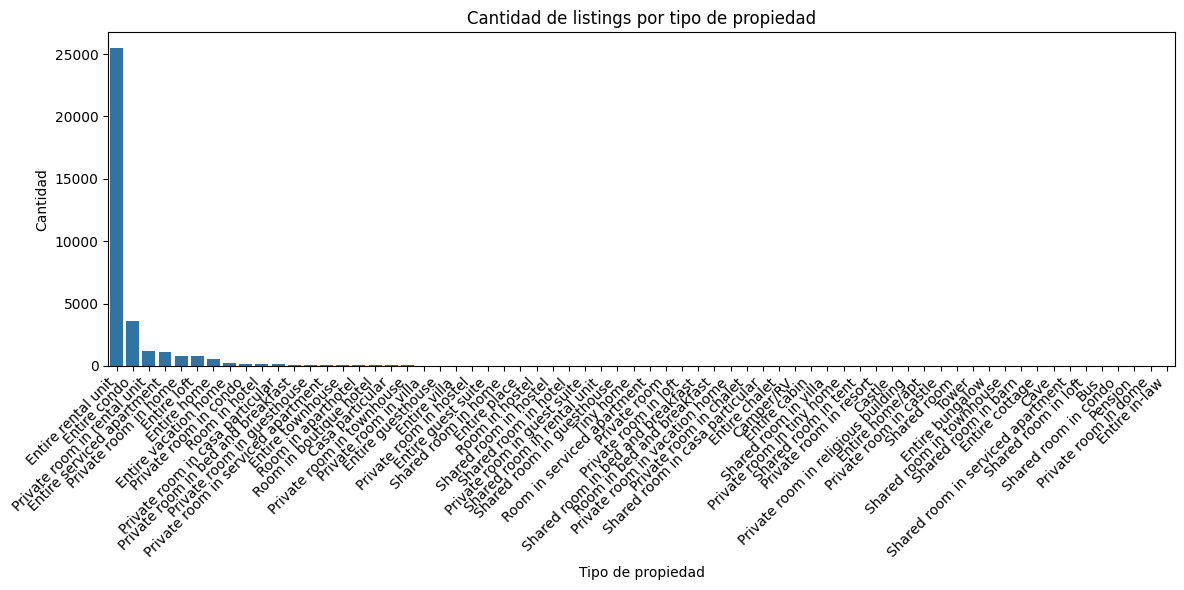

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# Obtener conteo de cada tipo de propiedad
counts = df_listings_columnas_interes['property_type'].value_counts()

# Convertir a DataFrame para usar con seaborn
counts_df = counts.reset_index()
counts_df.columns = ['property_type', 'count']

plt.figure(figsize=(12, 6))
sns.barplot(data=counts_df, x='property_type', y='count')
plt.title('Cantidad de listings por tipo de propiedad')
plt.xlabel('Tipo de propiedad')
plt.ylabel('Cantidad')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Vemos que "Entire rental unit" es la mayor parte de las unidades, seguido de "Entire condo". Esto puede implicar no tener suficientes datos para el resto de las categorías para analizar. Por lo tanto, creamos una columna 'property_type_summary', donde mantenemos los dos primeros tipos, y agrupamos el resto

In [51]:
def clasificar_alojamiento(row):
    tipo = row['property_type'].lower()
    if 'entire rental unit' in tipo:
        return 'entire_rental_unit'
    elif 'entire condo' in tipo:
        return 'entire_condo'
    elif 'shared room' in tipo:
        return 'habitacion_compartida'
    elif 'private room' in tipo:
        return 'habitacion_privada'
    elif 'entire' in tipo:
        return 'propiedad_completa_otros'
    else:
        return 'otros'

df_listings_columnas_interes['property_type_summary'] = df_listings_columnas_interes.apply(clasificar_alojamiento, axis =1)

C:\Users\alope\AppData\Local\Temp\ipykernel_28772\3212839271.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_columnas_interes['property_type_summary'] = df_listings_columnas_interes.apply(clasificar_alojamiento, axis =1)


In [52]:
# Convertimos el precio en float, limpiando los caracteres previamente
# Elimina símbolo de dólar, comas y espacios, luego convierte a float
df_listings_columnas_interes['price'] = (
    df_listings_columnas_interes['price']
    .replace('[\$,]', '', regex=True)  # quita $ y ,
    .astype(float)
)
# Analizamos la proporción de valores NaN en el precio
df_listings_columnas_interes['price'].isna().sum() / df_listings_columnas_interes.shape[0]


C:\Users\alope\AppData\Local\Temp\ipykernel_28772\3826552157.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_listings_columnas_interes['price'] = (


0.10161492095985443

In [53]:
# Analizamos la proporción de 0 en el precio
(df_listings_columnas_interes['price'] == 0).sum() / df_listings_columnas_interes.shape[0]

0.0

Analizamos la distribución del precio

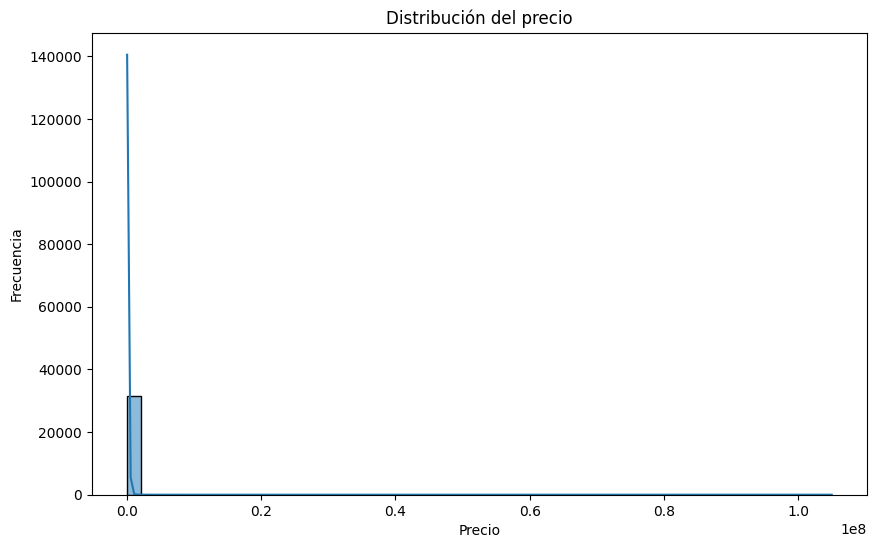

In [54]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df_listings_columnas_interes, x='price', bins=50, kde=True)
plt.title('Distribución del precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Se observa que hay valores muy elevados que distorsionan el gráfico

In [55]:
df_listings_columnas_interes['price'].describe()

count    3.159800e+04
mean     9.548776e+04
std      1.402656e+06
min      2.600000e+02
25%      2.971100e+04
50%      3.990800e+04
75%      5.776200e+04
max      1.050217e+08
Name: price, dtype: float64

Efectivamente hay un valor extremadamente elevado de precio. El mismo podría ser un outlier. Utilizamos 3*IQR para filtrarlo como outlier severo y volvemos a graficar

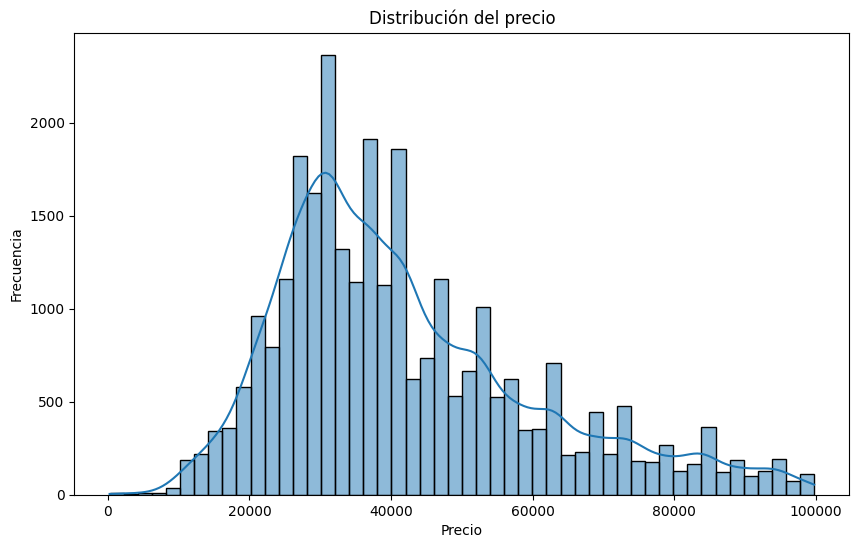

In [57]:
# Calcular cuartiles y rango intercuartílico
Q1 = df_listings_columnas_interes['price'].quantile(0.25)
Q3 = df_listings_columnas_interes['price'].quantile(0.75)
IQR = Q3 - Q1

# Definir límites inferior y superior
limite_inferior = Q1 - 1.5 * IQR
limite_superior = Q3 + 1.5 * IQR

# Filtrar outliers
df_sin_outliers = df_listings_columnas_interes[
    (df_listings_columnas_interes['price'] >= limite_inferior) &
    (df_listings_columnas_interes['price'] <= limite_superior)
]

plt.figure(figsize=(10, 6))
sns.histplot(data=df_sin_outliers, x='price', bins=50, kde=True)
plt.title('Distribución del precio')
plt.xlabel('Precio')
plt.ylabel('Frecuencia')
plt.show()

Ahora se observa la curva de precios con detalle. La mayor parte de las propiedades se ubican entre $20000 y $60000

#### Relación entre precio y tipo de alojameinto

In [58]:
df_property_type_price = df_sin_outliers[['property_type', 'property_type_summary', 'price']].copy()
# Dropeamos los NaN de precio que es la variable que queremos comparar
df_property_type_price.dropna(subset=['price'], inplace = True)

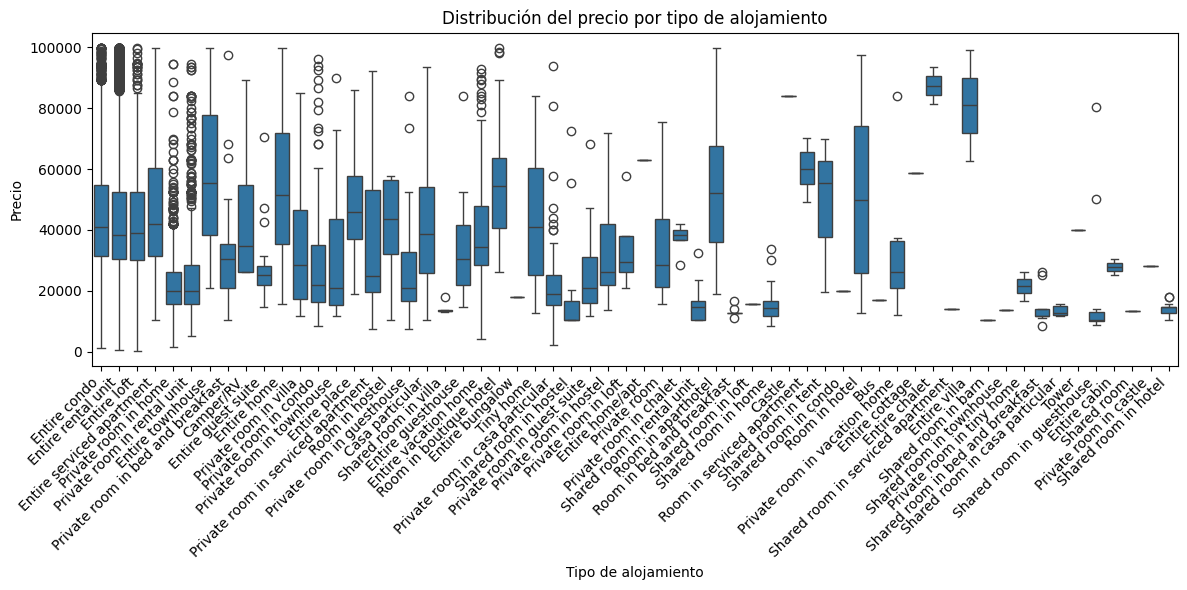

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_property_type_price, x='property_type', y='price')
plt.title('Distribución del precio por tipo de alojamiento')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Si bien se observan valores de boxplot más bajos, la cantidad de tipos de propiedades dificulta el análisis. Utilizamos el tipo de propiedad simplificado

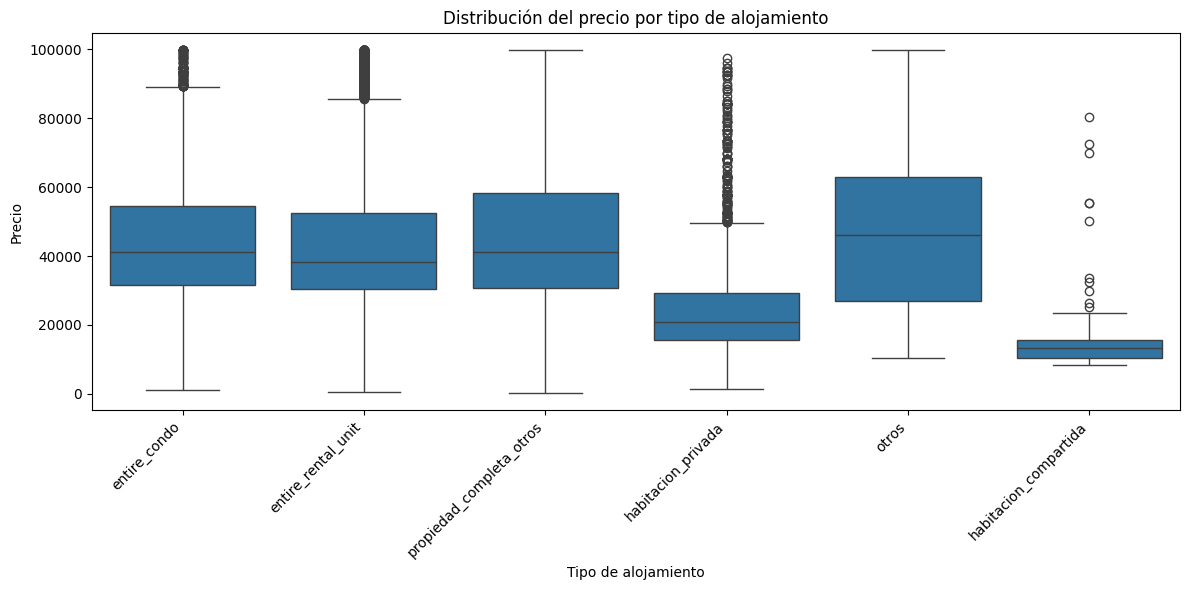

In [61]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_property_type_price, x='property_type_summary', y='price')
plt.title('Distribución del precio por tipo de alojamiento')
plt.xlabel('Tipo de alojamiento')
plt.ylabel('Precio')
plt.xticks(rotation=45, ha='right')  # rotación + alineación
plt.tight_layout()
plt.show()

Ahora sí observamos que:
- La habitación compartida tiene el precio más bajo en general
- La habitación privada tiene un precio algo más elevado al de la habitación compartida, pero menor al resto de los tipos de alojamiento. No obstante, tiene varios valores por encima que figuran como outliers
- El resto de los tipos tiene valores de precios en general similares